# Lectura y graficación de la señal EMG capturada

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import re

## Abrimos los archivos txt para ver  el contenido

In [2]:
r = open("ecg_reposo.txt","r")
raw_data = r.readlines()[1]
r.close()
print(raw_data)


# {"98:D3:71:FD:62:1F": {"position": 0, "device": "bitalino_rev", "device name": "98:D3:71:FD:62:1F", "device connection": "BTH98:D3:71:FD:62:1F", "sampling rate": 1000, "resolution": [4, 1, 1, 1, 1, 10], "firmware version": 1282, "comments": "", "keywords": "", "mode": 0, "sync interval": 2, "date": "2023-4-12", "time": "11:41:7.526", "channels": [2], "sensor": ["ECGBIT"], "label": ["A2"], "column": ["nSeq", "I1", "I2", "O1", "O2", "A2"], "special": [{}], "digital IO": [0, 0, 1, 1]}}



In [3]:
## Regex para extraer la frecuencia
x = re.findall("[0-5][0-9][0-9]\d", raw_data)[0]

print(x)

1000


In [4]:
Fs = float(x)
Ts=1/Fs # Determinar el periodo de muestreo

print(f" Fs={Fs} hz\n Ts={Ts} s")

 Fs=1000.0 hz
 Ts=0.001 s


## Leyendo el archivo excluyendo las primeras 3 filas

In [5]:
a_r = np.genfromtxt("ecg_patron.txt", delimiter="\t",skip_header = 3)

## Ploteamos la lectura

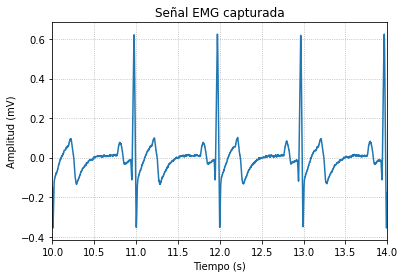

El periodo de la señal en resposo es: 1.00 s, es decir 60.24bpm


In [8]:
import scipy.signal as signal
bits = 10 # Bits de la salida 
volt_range = 3.28 #Rango de voltaje en milivoltios (-1.64; 1.64) mV
# Extraer la penultima columna (datos)
y_1 = (a_r[: ,-2] * volt_range/(2**bits - 1)) # convertir los bits a mV
y_1 = y_1 - np.mean(y_1) # Centrar la señal, ya que va de -1.64 a 1.64
t_1 = np.arange(0, len(y_1)*Ts, Ts) # Crear vector de tiempo considerando periodo de muestreo


plt.plot(t_1, y_1, label="señal") # Señal completa
plt.title("Señal EMG capturada");plt.xlim(10, 14)
plt.grid(linestyle=":")
plt.xlabel("Tiempo (s)") 
plt.ylabel("Amplitud (mV)")
fig = plt.gcf()
fig.set_facecolor('white')
plt.savefig('complete_signal.png', transparent=False, )
plt.show()


pk_loc1 = signal.find_peaks(y_1[int(10.5*Fs):int(12.5*Fs)], height=0.4)[0]
T1 = t_1[pk_loc1[1]] - t_1[pk_loc1[0]]
bpm1 = (1/T1) * 60
print(f"El periodo de la señal en resposo es: {T1:.2f} s, es decir {bpm1:.2f}bpm")

## Dominio de la frecuencia

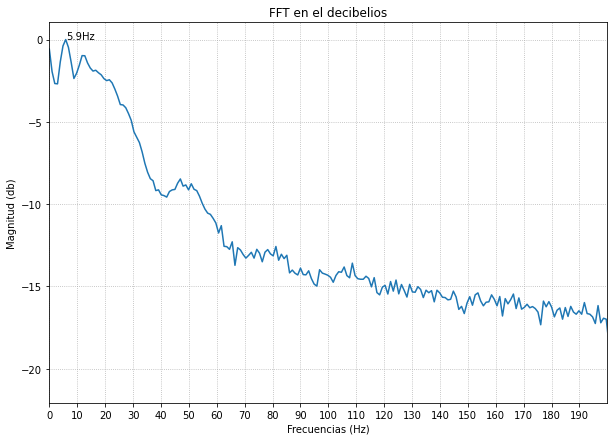

In [9]:

N = 2**bits                                    

signal1 = y_1

signal_fft = np.fft.fft(signal1, N)           # fft magtinud
signal_fft = np.round(np.abs(signal_fft),3)[0:N//2] # nos quedamos con los componente de la derecha de la FFT
signal_aux = signal_fft/signal_fft.max()     # hallamos el maximo para pasar la magnitud a escala db

with np.errstate(divide='ignore'):
    signal_fft_db = 10*np.log10(signal_aux)  

F_list = np.linspace(0,Fs/2, N//2)
F = np.round(F_list[np.argmax(signal_fft_db)], 1)  
plt.plot(F_list, signal_fft_db)
plt.text(F,0, f"{F}Hz")
plt.grid(linestyle=":")
plt.ylabel("Magnitud (db)")
plt.xlabel("Frecuencias (Hz)")
plt.title("FFT en el decibelios")
plt.xlim([0,200])
plt.xticks(np.arange(0,200,10))
fig = plt.gcf()
fig.set_facecolor('white')
fig.set_size_inches(10, 7)
plt.savefig('fft.png', transparent=False, )
plt.show()
